In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

In [2]:
np.load('increments.npz').files

['ensX', 'X_inc', 't_obs', 'l_obs', 't_inc', 'X_truth', 'Y_truth', 't_truth']

In [3]:
dt_inc = np.diff( np.load('increments.npz')['t_inc'] )[0]
dt = np.diff( np.load('increments.npz')['t_truth'] )[0]
da_interval = int( dt_inc/dt )

# Data from DA system (increments for individual ensemble members)
x_input = np.load('increments.npz')['ensX'][:-1:da_interval]
X_tend = np.load('increments.npz')['X_inc'] / dt_inc

# Ensemble mean increments from DA system (1/50th of data above)
# x_input = np.load('increments.npz')['ensX'][:-1:da_interval].mean(axis=-1)
# X_tend = np.load('increments.npz')['X_inc'].mean(axis=-1) / dt_inc

# # Truth tendencies (proxy for LES)
# x_input = np.load('increments.npz')['X_truth']
# X_tend = -np.load('increments.npz')['Y_truth'].reshape((4001,8,32)).sum(axis=-1)

In [4]:
whos

Variable      Type       Data/Info
----------------------------------
X_tend        ndarray    400x8x50: 160000 elems, type `float64`, 1280000 bytes (1.220703125 Mb)
da_interval   int        10
dt            float64    0.005
dt_inc        float64    0.05
np            module     <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
plt           module     <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
torch         module     <module 'torch' from 'C:\<...>ges\\torch\\__init__.py'>
x_input       ndarray    400x8x50: 160000 elems, type `float64`, 1280000 bytes (1.220703125 Mb)


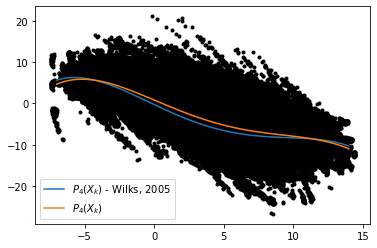

In [5]:
x = np.linspace(-7,14,100)
p = np.polyfit(x_input.flatten(), X_tend.flatten(), 4)
p18 = [0.000707, -0.0130, -0.0190, 1.59, 0.275] # Polynomial from Wilks, 2005
plt.plot(x_input.flatten(), X_tend.flatten(), 'k.' );
plt.plot(x, -np.polyval(p18, x), label='$P_4(X_k)$ - Wilks, 2005');
plt.plot(x, np.polyval(p, x), label='$P_4(X_k)$');
plt.legend();

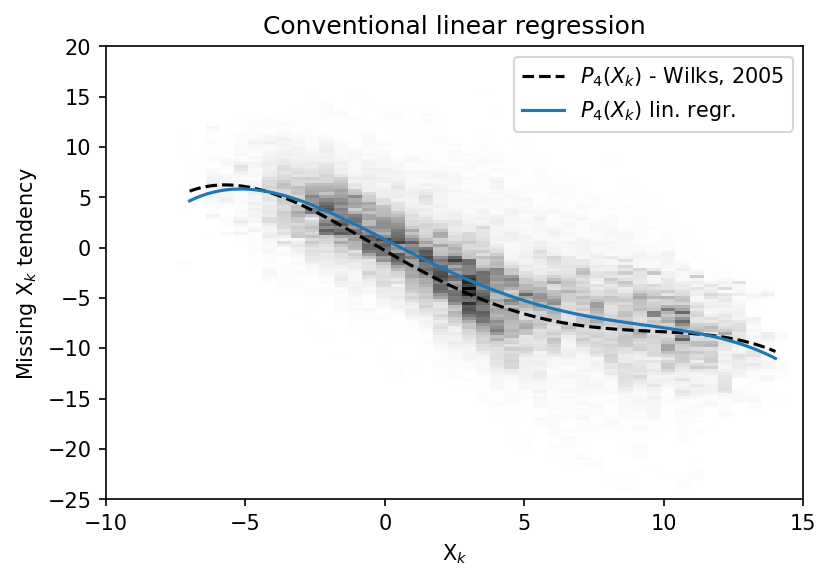

In [6]:
plt.figure(dpi=150)
plt.hist2d(x_input.flatten(), X_tend.flatten(), bins=(np.linspace(-10,15,50),np.linspace(-25,20,150)), cmap=plt.cm.Greys );
plt.plot(x, -np.polyval(p18, x), 'k--', label='$P_4(X_k)$ - Wilks, 2005');
plt.plot(x, np.polyval(p, x), label='$P_4(X_k)$ lin. regr.');
plt.legend(); plt.xlabel('X$_k$'); plt.ylabel('Missing X$_k$ tendency'); plt.title('Conventional linear regression');

In [7]:
train_size = x_input.size//2
print('Training set size = ', train_size, ' out of ', x_input.size)
X_train = x_input.flatten()[:train_size]
Y_train = X_tend.flatten()[:train_size]
X_valid = x_input.flatten()[train_size:]
Y_valid = X_tend.flatten()[train_size:]

Training set size =  80000  out of  160000


In [8]:
local_torch_dataset_train = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).double(),
    torch.from_numpy(Y_train).double() )

BATCH_SIZE = 1024 # Number of sample in each batch

loader_train = torch.utils.data.DataLoader( dataset=local_torch_dataset_train, batch_size=BATCH_SIZE, shuffle=True )

In [9]:
local_torch_dataset_valid = torch.utils.data.TensorDataset(
    torch.from_numpy(X_valid).double(),
    torch.from_numpy(Y_valid).double() )

loader_valid = torch.utils.data.DataLoader( dataset=local_torch_dataset_valid, batch_size=BATCH_SIZE, shuffle=True )

In [10]:
#define network structure in pytorch 
class Net_ANN(torch.nn.Module):
    def __init__(self, W=16):
        super(Net_ANN, self).__init__()
        self.linear1 = torch.nn.Linear(1, W) # 1 inputs, W neurons for first hidden layer
        self.linear2 = torch.nn.Linear(W, W) # W neurons for second hidden layer
#         self.linear2a = torch.nn.Linear(W, W) # W neurons for second hidden layer
#         self.linear2b = torch.nn.Linear(W, W) # W neurons for second hidden layer
        self.linear3 = torch.nn.Linear(W, 1) # 1 outputs
#         self.lin_drop = nn.Dropout(0.1) # regularization method to prevent overfitting. 

    def forward(self, x):
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
#         x = torch.nn.functional.relu(self.linear2a(x))
#         x = torch.nn.functional.relu(self.linear2b(x))
        x = self.linear3(x)
        return x

In [11]:
def train_model(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = torch.autograd.Variable(batch_x) # Inputs
        b_y = torch.autograd.Variable(batch_y) # outputs
        if len(b_x.shape) == 1: # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)   # Calculating loss 
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights

def test_model(net, criterion, testloader, optimizer, text='validation'):
    net.eval() # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(testloader):  # for each training step
            b_x = torch.autograd.Variable(batch_x) # Inputs
            b_y = torch.autograd.Variable(batch_y) # outputs
            if len(b_x.shape) == 1: # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)   # Calculating loss 
            test_loss = test_loss + loss.data.numpy() # Keep track of the loss 
        test_loss /= len(testloader) # dividing by the number of batches
    return test_loss

In [12]:
criterion = torch.nn.MSELoss() # MSE loss function

In [13]:
torch.manual_seed(14) # For reproducibility 
nn_3l = Net_ANN(W=16).double()

Epoch =   1 Training loss = 15.800228311284721 	Validation loss = 16.593061421179797
Epoch =   2 Training loss = 15.638358619931253 	Validation loss = 16.432247726761094
Epoch =   3 Training loss = 15.586144717273022 	Validation loss = 16.26179343131813
Epoch =   4 Training loss = 15.544309059059339 	Validation loss = 16.31254618075822
Epoch =   5 Training loss = 15.439358029016402 	Validation loss = 16.298665236081284
Epoch =   6 Training loss = 15.433131730969986 	Validation loss = 16.236854950388274
Epoch =   7 Training loss = 15.463809603906263 	Validation loss = 16.269148448309338
Epoch =   8 Training loss = 15.437331550766068 	Validation loss = 16.24434084560198
Epoch =   9 Training loss = 15.467301215916073 	Validation loss = 16.239120786982948
Epoch =  10 Training loss = 15.455056558736343 	Validation loss = 16.36925064974302
Epoch =  11 Training loss = 15.443175148175364 	Validation loss = 16.24024991149216
Epoch =  12 Training loss = 15.497565597831588 	Validation loss = 16.2

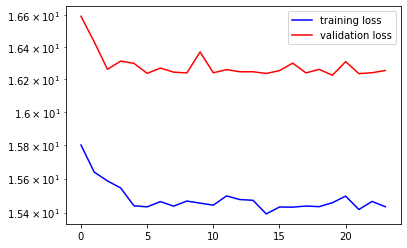

In [14]:
n_epochs = 24 # Number of epocs
optimizer = torch.optim.Adam(nn_3l.parameters(), lr=0.003)
validation_loss = list()
train_loss = list()
# train_loss.append(test_model(nn_3l, criterion,loader_train, optimizer, 'train'))
# validation_loss.append(test_model(nn_3l, criterion, loader_valid, optimizer))
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader_train, optimizer)
    train_loss.append(test_model(nn_3l, criterion,loader_train, optimizer, 'train'))
    validation_loss.append(test_model(nn_3l, criterion, loader_valid, optimizer))
    print('Epoch = %3i'%(epoch), 'Training loss =', train_loss[-1], '\tValidation loss =', validation_loss[-1])
plt.semilogy(train_loss,'b', label='training loss');
plt.semilogy(validation_loss,'r', label='validation loss');

plt.legend();

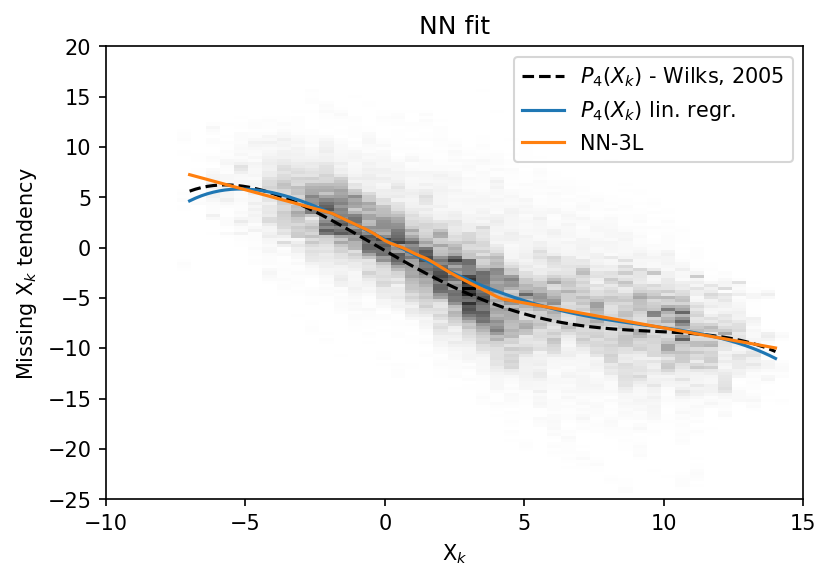

In [15]:
plt.figure(dpi=150)
plt.hist2d(x_input.flatten(), X_tend.flatten(), bins=(np.linspace(-10,15,50),np.linspace(-25,20,150)), cmap=plt.cm.Greys );
plt.plot(x, -np.polyval(p18, x), 'k--', label='$P_4(X_k)$ - Wilks, 2005');
plt.plot(x, np.polyval(p, x), label='$P_4(X_k)$ lin. regr.');
plt.plot(x, ( nn_3l( torch.unsqueeze( torch.from_numpy( x ), 1) ) ).data.numpy(), label='NN-3L' )
plt.legend(); plt.xlabel('X$_k$'); plt.ylabel('Missing X$_k$ tendency'); plt.title('NN fit');